<a href="https://colab.research.google.com/github/nicolai5965/Predictive_Text_Generation_with_LSTM_model/blob/main/Predictive_Text_Generation_with_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from nltk.corpus import words

# Download the words corpus if you haven't done so already
import nltk
nltk.download('words')

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from google.colab import drive
# Mount Google Drive to load the dataset
drive.mount('/content/drive') 

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 19 05:21:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [4]:
# Define the file path and load the train and test data
filepath = '/content/drive/My Drive/Colab Notebooks/Machine Learning/TensorFlow/GRU/'

In [5]:
df = pd.read_csv(f'{filepath}fake_or_real_news.csv')


In [6]:
display(df)

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [7]:
def prepare_text_data(df, column_name, data_proportion, test_size, fixed_sequence_len, fixed_n_gram_len):
    # Extract text data
    text = list(df[column_name].values)

    # Determine the number of samples to use
    num_samples = int(len(text) * data_proportion)

    # Use only the specified proportion of samples
    text = text[:num_samples]

    # Lowercasing: Convert all text to lowercase.
    text = [t.lower() for t in text]

    # Split data into training and validation sets
    train_text, val_text = train_test_split(text, test_size=test_size, random_state=42)

    # Define tokenizer
    tokenizer = Tokenizer()

    # Fit tokenizer on training text data
    tokenizer.fit_on_texts(train_text)

    # Total number of words before removal
    total_words_before_removal = len(tokenizer.word_index) + 1

    # Remove words that are not recognized as English words
    english_words = set(words.words())
    tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if word in english_words}
    removed_words = list(set(tokenizer.word_index.keys()) - english_words)

    # Update total_words after removal
    total_words = len(tokenizer.word_index) + 1

    # Function to convert text data to sequence of tokens
    def text_to_sequences(text_data):
        input_sequences = []
        for line in text_data:
            token_list = tokenizer.texts_to_sequences([line])[0]
            for i in range(0, len(token_list) - fixed_n_gram_len + 1):
                n_gram_sequence = token_list[i:i + fixed_n_gram_len]
                input_sequences.append(n_gram_sequence)
        return input_sequences

    # Convert training and validation text data to sequences
    train_sequences = text_to_sequences(train_text)
    val_sequences = text_to_sequences(val_text)

    # Pad sequences
    train_sequences = np.array(pad_sequences(train_sequences, maxlen=fixed_sequence_len, padding='pre'))
    val_sequences = np.array(pad_sequences(val_sequences, maxlen=fixed_sequence_len, padding='pre'))

    # Create predictors and labels for both training and validation sets
    train_x, train_y = train_sequences[:, :-1], train_sequences[:, -1]
    val_x, val_y = val_sequences[:, :-1], val_sequences[:, -1]

    # Convert to numpy array and set out-of-range indices to 0
    train_y, val_y = np.array(train_y), np.array(val_y)
    train_y[train_y >= total_words], val_y[val_y >= total_words] = 0, 0

    # Convert labels to categorical
    train_y = tf.keras.utils.to_categorical(train_y, num_classes=total_words)
    val_y = tf.keras.utils.to_categorical(val_y, num_classes=total_words)

    return (train_x, train_y), (val_x, val_y), total_words, tokenizer, removed_words

In [8]:
# Custom LSTM cell
class LSTMCell(Layer):
    # Initialize LSTM cell with given parameters
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', kernel_regularizer=None, recurrent_regularizer=None, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.units = units # Number of LSTM units
        self.activation = tf.keras.activations.get(activation) # Activation function for cell state
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation) # Activation function for gates
        self.kernel_regularizer = regularizers.get(kernel_regularizer) # Regularizer function applied to the input weights
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)  # Regularizer function applied to the recurrent weights

    def build(self, input_shape):
        # Input gate weights
        self.kernel_i = self.add_weight(shape=(input_shape[-1], self.units),
                                        initializer='glorot_uniform',
                                        name='kernel_i',
                                        regularizer=self.kernel_regularizer)
        self.recurrent_kernel_i = self.add_weight(shape=(self.units, self.units),
                                                  initializer='orthogonal',
                                                  name='recurrent_kernel_i',
                                                  regularizer=self.recurrent_regularizer)
        self.bias_i = self.add_weight(shape=(self.units,), initializer='zeros', name='bias_i')
        # Forget gate weights
        self.kernel_f = self.add_weight(shape=(input_shape[-1], self.units),
                                        initializer='glorot_uniform',
                                        name='kernel_f',
                                        regularizer=self.kernel_regularizer)
        self.recurrent_kernel_f = self.add_weight(shape=(self.units, self.units),
                                                  initializer='orthogonal',
                                                  name='recurrent_kernel_f',
                                                  regularizer=self.recurrent_regularizer)
        self.bias_f = self.add_weight(shape=(self.units,), initializer='zeros', name='bias_f')
        # Cell state weights
        self.kernel_c = self.add_weight(shape=(input_shape[-1], self.units),
                                        initializer='glorot_uniform',
                                        name='kernel_c',
                                        regularizer=self.kernel_regularizer)
        self.recurrent_kernel_c = self.add_weight(shape=(self.units, self.units),
                                                  initializer='orthogonal',
                                                  name='recurrent_kernel_c',
                                                  regularizer=self.recurrent_regularizer)
        self.bias_c = self.add_weight(shape=(self.units,), initializer='zeros', name='bias_c')
        # Output gate weights
        self.kernel_o = self.add_weight(shape=(input_shape[-1], self.units),
                                        initializer='glorot_uniform',
                                        name='kernel_o',
                                        regularizer=self.kernel_regularizer)
        self.recurrent_kernel_o = self.add_weight(shape=(self.units, self.units),
                                                  initializer='orthogonal',
                                                  name='recurrent_kernel_o',
                                                  regularizer=self.recurrent_regularizer)
        self.bias_o = self.add_weight(shape=(self.units,), initializer='zeros', name='bias_o')

        self.built = True # Set built to True after weights initialization

    def call(self, inputs, states):
        prev_output = states[0]
        prev_cell_state = states[1]

        # Input gate calculation
        i = self.recurrent_activation(tf.matmul(inputs, self.kernel_i) + tf.matmul(prev_output, self.recurrent_kernel_i) + self.bias_i) # The input gate decides how much of the new information from the current input should be stored in the cell state. It uses a sigmoid activation function to squash the values between 0 and 1, with 0 meaning "store nothing" and 1 meaning "store everything".

        # Forget gate calculation
        f = self.recurrent_activation(tf.matmul(inputs, self.kernel_f) + tf.matmul(prev_output, self.recurrent_kernel_f) + self.bias_f) # The forget gate decides how much of the past cell state should be forgotten or erased. It also uses a sigmoid activation function, with 0 meaning "forget everything" and 1 meaning "forget nothing".

        # Cell state candidate
        c_candidate = self.activation(tf.matmul(inputs, self.kernel_c) + tf.matmul(prev_output, self.recurrent_kernel_c) + self.bias_c) # This is a candidate for values that could be added to the cell state. It is created by applying a tanh activation function to the current input and the previous hidden state, squashing the values between -1 and 1.

        # Cell state update
        c = f * prev_cell_state + i * c_candidate # The cell state is updated by a combination of the forget gate, the previous cell state, the input gate, and the cell state candidate. The forget gate decides what to forget from the previous cell state, and the input gate decides what to add from the current cell state candidate.

        # Output gate calculation
        o = self.recurrent_activation(tf.matmul(inputs, self.kernel_o) + tf.matmul(prev_output, self.recurrent_kernel_o) + self.bias_o) # The output gate decides what the next hidden state should be. This is the output that will be used for predictions and will be passed to the next time step. It uses a sigmoid activation function to decide which parts of the cell state make it to the output.

        # Final output calculation
        output = o * self.activation(c) # The final output, also known as the hidden state, is computed as a combination of the output gate and the updated cell state passed through a tanh activation function. This output will be used for predictions and will be passed to the LSTM cell in the next time step.

        return output, [output, c]

    def get_initial_state(self, inputs):
        # Get the batch size from the shape of the inputs
        batch_size = tf.shape(inputs)[0]

        # Return a list of two zero tensors with shape [batch_size, self.units]
        # The first tensor represents the initial hidden state
        # The second tensor represents the initial cell state
        return [tf.zeros([batch_size, self.units], dtype=inputs.dtype), tf.zeros([batch_size, self.units], dtype=inputs.dtype)]

In [9]:
# Custom LSTM layer
class LSTM(Layer):
    # Initialize LSTM layer with cell, return_sequences and return_state parameters
    def __init__(self, cell, return_sequences=False, return_state=False, **kwargs):
        super(LSTM, self).__init__(**kwargs)
        self.cell = cell # LSTM cell
        self.return_sequences = return_sequences # Boolean to determine if output at all steps should be returned
        self.return_state = return_state # Boolean to determine if the last state should be returned

    # Define the computation during the layer call
    def call(self, inputs):
        # Get the initial state from the LSTM cell
        initial_state = self.cell.get_initial_state(inputs)
        states = initial_state

        # Initialize list to store outputs at each time step
        outputs = []
        for t in range(inputs.shape[1]):
            input_t = inputs[:, t] # Input at time step t
            output, states = self.cell(input_t, states) # Output and states at time step t
            outputs.append(output)

        # Stack the outputs from all time steps along the time axis
        outputs = tf.stack(outputs, axis=1)
        # Return outputs and states based on the return_sequences and return_state attributes
        if self.return_sequences:
            if self.return_state:
                return outputs, states # Return outputs at all time steps and the final states
            else:
                return outputs # Return outputs at all time steps
        else:
            if self.return_state:
                return outputs[:, -1], states # Return output at last time step and the final states
            else:
                return outputs[:, -1] # Return output at last time step


In [10]:
class Model(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_units, max_features, l2_reg):
        super(Model, self).__init__() # Call the parent class initializer
        self.embedding = Embedding(input_dim=max_features, output_dim=embedding_dim) # Define the embedding layer
        self.lstm_cell = LSTMCell(units=hidden_units, kernel_regularizer=regularizers.l2(l2_reg), recurrent_regularizer=regularizers.l2(l2_reg)) # Define the LSTM cell
        self.lstm = LSTM(self.lstm_cell, return_sequences=False) # Define the LSTM layer
        self.dense = Dense(max_features, activation='softmax') # Define the output layer

    def call(self, inputs):
        x = self.embedding(inputs) # Pass the input through the embedding layer
        x = self.lstm(x) # Pass the output of the embedding layer through the LSTM layer
        return self.dense(x) # Pass the output of the LSTM layer through the output layer


In [11]:
# Data preprocessing configuration
preprocessing_config = {
    'data_proportion': 0.04,
    'text_split_size': 0.2,
    'fixed_sequence_len': 25,
    'fixed_n_gram_len': 20
}


In [12]:
# Prepare the text data
(train_x, train_y), (val_x, val_y), total_words, tokenizer, removed_words = prepare_text_data(df, 
                                                                    'text', 
                                                                    preprocessing_config['data_proportion'], 
                                                                    preprocessing_config['text_split_size'],
                                                                    preprocessing_config['fixed_sequence_len'], 
                                                                    preprocessing_config['fixed_n_gram_len'])

In [13]:
# Display shape of predictors and label
print("Train Predictors shape:", train_x.shape)
print("Train Label shape:", train_y.shape)
print("Validation Predictors shape:", val_x.shape)
print("Validation Label shape:", val_y.shape)

# Display an example predictor and label
print("Example Predictor:", train_x[0])
print("Example Label:", train_y[0])

# Display the total number of unique words
print("Total number of unique words:", total_words)

# Output removed words
if len(removed_words) > 0:
    print("Number of words removed:", len(removed_words))
    print("Removed words:", removed_words)
else:
    print("No words were removed.")

Train Predictors shape: (111441, 24)
Train Label shape: (111441, 7324)
Validation Predictors shape: (34092, 24)
Validation Label shape: (34092, 7324)
Example Predictor: [   0    0    0    0    0 3535 2662  513   19    5  996  550 1493   31
 2663    4   44  531  295   74  996 1393   17    8]
Example Label: [0. 0. 0. ... 0. 0. 0.]
Total number of unique words: 7324
No words were removed.


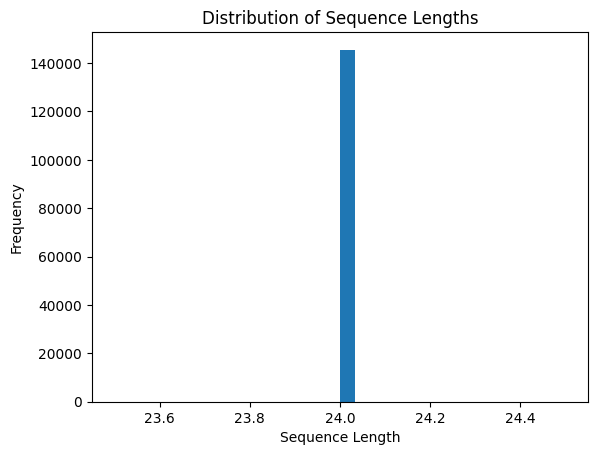

10 most common words: [('the', 8282), ('to', 4266), ('of', 3710), ('and', 3592), ('a', 3198), ('in', 2955), ('that', 1995), ('is', 1515), ('on', 1361), ('for', 1306)]
10 least common words: [('tick', 1), ('tock', 1), ('“they’ve', 1), ('bernie’s', 1), ('roseann', 1), ('demoro', 1), ('185', 1), ('dean', 1), ('88', 1), ('endorsing', 1)]
Number of words that appear only once: 7074
Example original text: Daniel Greenfield, a
Example tokenized text: [5, 2716, 1088, 25, 1, 523, 410, 8, 5, 54, 188, 2700, 9, 2844, 6, 1, 757, 1105, 3, 1]


In [14]:
# Display distribution of sequence lengths
sequence_lengths = [len(seq) for seq in np.concatenate([train_x, val_x])]
plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Get word counts
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Display most common and least common words
print("10 most common words:", sorted_word_counts[:10])
print("10 least common words:", sorted_word_counts[-10:])

# Count and display number of words that appear only once
single_appearance_words = len([count for word, count in word_counts.items() if count == 1])
print("Number of words that appear only once:", single_appearance_words)

# Display example of original text and its tokenized equivalent
example_text = df['text'][0]  # As the original text isn't directly returned by the function anymore
example_tokens = tokenizer.texts_to_sequences([example_text])[0]
print("Example original text:", example_text[:20])
print("Example tokenized text:", example_tokens[:20])


In [15]:
# Model configuration
model_config = {
    'embedding_dim': 100,
    'hidden_units': 32,
    'max_features': total_words,
    'l2_reg': 1e-4,
    'optimizer': 'RMSprop',
    'learning_rate': 0.01,
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'batch_size': 256,
    'epochs': 10,
    'validation_split': 0.2,
    'patience': 5,
    'verbose': 2
}

In [16]:
# Create and compile the model
model = Model(model_config['embedding_dim'], model_config['hidden_units'], model_config['max_features'], model_config['l2_reg'])
model.compile(optimizer=RMSprop(learning_rate=model_config['learning_rate']), 
              loss=model_config['loss'], 
              metrics=model_config['metrics'])

# Define the early stopping callback with the desired parameters
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=model_config['patience'], 
                               restore_best_weights=True)

# Specify the path where you want to save the model
checkpoint_filepath = '/content/drive/My Drive/Colab Notebooks/Machine Learning/TensorFlow/LSTM/LSTM_best_model_callback/'

# Create a ModelCheckpoint callback that saves the weights only during training
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [17]:
# Train the model
history = model.fit(train_x, 
                    train_y, 
                    epochs=model_config['epochs'], 
                    batch_size=model_config['batch_size'], 
                    validation_data=(val_x, val_y), 
                    callbacks=[early_stopping, model_checkpoint_callback], 
                    verbose=model_config['verbose'])

Epoch 1/10
436/436 - 53s - loss: 6.2470 - accuracy: 0.0874 - val_loss: 6.1477 - val_accuracy: 0.0965 - 53s/epoch - 121ms/step
Epoch 2/10
436/436 - 14s - loss: 5.9083 - accuracy: 0.1170 - val_loss: 5.9423 - val_accuracy: 0.1080 - 14s/epoch - 33ms/step
Epoch 3/10
436/436 - 15s - loss: 5.7793 - accuracy: 0.1267 - val_loss: 5.8944 - val_accuracy: 0.1180 - 15s/epoch - 35ms/step
Epoch 4/10
436/436 - 14s - loss: 5.6977 - accuracy: 0.1332 - val_loss: 5.8848 - val_accuracy: 0.1167 - 14s/epoch - 32ms/step
Epoch 5/10
436/436 - 14s - loss: 5.6295 - accuracy: 0.1386 - val_loss: 5.8513 - val_accuracy: 0.1227 - 14s/epoch - 33ms/step
Epoch 6/10
436/436 - 15s - loss: 5.5726 - accuracy: 0.1424 - val_loss: 5.8636 - val_accuracy: 0.1214 - 15s/epoch - 34ms/step
Epoch 7/10
436/436 - 14s - loss: 5.5210 - accuracy: 0.1469 - val_loss: 5.8586 - val_accuracy: 0.1222 - 14s/epoch - 32ms/step
Epoch 8/10
436/436 - 13s - loss: 5.4725 - accuracy: 0.1513 - val_loss: 5.8327 - val_accuracy: 0.1244 - 13s/epoch - 31ms/step

In [18]:
display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  732400    
                                                                 
 lstm_cell (LSTMCell)        multiple                  17024     
                                                                 
 lstm (LSTM)                 multiple                  17024     
                                                                 
 dense (Dense)               multiple                  241692    
                                                                 
Total params: 991,116
Trainable params: 991,116
Non-trainable params: 0
_________________________________________________________________


None

In [19]:
def predict_next_word(model, tokenizer, input_text, fixed_sequence_len, n_best=3):
    # Tokenize the input text
    input_tokens = tokenizer.texts_to_sequences([input_text])[0]
    # Pad the tokens
    input_tokens = pad_sequences([input_tokens], maxlen=fixed_sequence_len-1, padding='pre')
    # Predict the probabilities for the next word
    probabilities = model.predict(input_tokens, verbose=0)
    # Get the indices of the n_best most probable next words
    top_indices = np.argpartition(probabilities[0], -n_best)[-n_best:]
    # Get these indices sorted by probability
    sorted_indices = top_indices[np.argsort(-probabilities[0][top_indices])]
    # Reverse the word index
    reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
    # Filter valid indices
    valid_indices = [i for i in sorted_indices if i in reverse_word_index and i != 0]  # <-- Modified line
    # Look up the words corresponding to the valid indices
    next_words = [reverse_word_index[i] for i in valid_indices]  # <-- Modified line
    # Look up the probabilities corresponding to the valid indices
    likelihoods = probabilities[0][valid_indices]  # <-- Modified line
    # Create a DataFrame with the words and their likelihoods
    df = pd.DataFrame({
        'Word': next_words,
        'Likelihood': [f"{likelihood * 100:.2f}%" for likelihood in likelihoods]
    })
    return df

best_words = 3

possible = predict_next_word(model, tokenizer, "The economic outlook for the next year has been released and it suggests that the growth rate will", preprocessing_config['fixed_sequence_len'])
display(possible)
possible = predict_next_word(model, tokenizer, "In the world of artificial intelligence, recent advancements have led to a renewed interest in developing systems that can", preprocessing_config['fixed_sequence_len'])
display(possible)
possible = predict_next_word(model, tokenizer, "Climate change is having a dramatic effect on global weather patterns, and scientists are warning that if we don't", preprocessing_config['fixed_sequence_len'])
display(possible)

,Word,Likelihood
0,be,22.85%
1,not,13.15%
2,have,2.46%


,Word,Likelihood
0,be,9.39%
1,the,4.14%


,Word,Likelihood
0,are,16.65%
1,have,15.77%
2,will,5.39%


In [20]:
def generate_text(model, tokenizer, input_text, fixed_sequence_len, n_words, creativity=3):
    # Split the input text into a list of words
    word_sequence = input_text.split()
    # Generate the specified number of words
    for _ in range(n_words):
        sub_sequence = " ".join(word_sequence[-fixed_sequence_len:])
        try:
            # Predict the next word based on the sub_sequence
            predictions = predict_next_word(model, tokenizer, sub_sequence, fixed_sequence_len, n_best=creativity)
            # Sort the predictions by likelihood
            predictions.sort_values(by='Likelihood', ascending=False, inplace=True)
            # Get the top 'creativity' predictions
            top_predictions = predictions.head(creativity)['Word'].tolist()
            # Randomly choose one of the top predictions
            choice = random.choice(top_predictions)
        except Exception as e:
            print(f"Error during prediction: {e}")
            choice = random.choice(word_sequence)
        word_sequence.append(choice)
    return " ".join(word_sequence)

# Define the input string
input_string = "The economic outlook for the next year has been released and it suggests that the growth rate will"
generated_text = generate_text(model, tokenizer, input_string, preprocessing_config['fixed_sequence_len'], n_words=100, creativity=3)
print(generated_text)


The economic outlook for the next year has been released and it suggests that the growth rate will not be the of the and of and that the only one in the of a more than a more than a lot in a more than the of and a lot of and the only of our country and the of a more and and the of a more and and the world the are the of a more and the world the are a lot in the only time in the of our country and the of a lot of the of the time of and i have been by the of a more and the of a
